# Test loading elevation maps

Goal is to capture all of the data in the maps, with NaNs when missing, and have a grid rotated alongshore to facilitate erosion calcs.

TODO:
* Make a rotated grid big enough to accomodate all of the maps. What resolution?
* Assign UTM values to for rotated grid.
* Load each map, [smooth?], and interpolate onto rotated grid.
* Stack all maps. Work in rotated grid coordintes.
* Save
    

In [3]:
import json
import fiona
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import rasterio # rasterio and OGR don't mix...see rasterio docs
from rasterio import Affine
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [4]:
# top left corner of big region of interest (UTM Zone 19N meters)
e0 = 376200.; n0 = 4625500.


In [6]:
fdir = "F:/2017_Karen_Sandwich_maps"
#fdir = "C:/crs/proj/2017_Karen_Sandwich_maps"

fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
"DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif")

dslist =[]
# just read on for now
fn = fdir+"/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif"
ds = xr.open_rasterio(fn)
#     ds = ds.sel(x=slice(e0,e1), y=slice(n0,n1))
#     if len(dslist) == 0:
#         xc = ds['x']-ds['x'].values.min()
#         yc = ds['y']-ds['y'].values.min()
#     ds['x'] = xc
#     ds['y'] = yc
#     dslist.append(ds)

In [7]:
# look to see what got loaded
ds['x'].values.min()
ds['y'].values.min()
print(ds.sizes)
print(ds.dims)
print(ds.indexes)

Frozen(OrderedDict([('band', 1), ('y', 10226), ('x', 11987)]))
('band', 'y', 'x')
band: Int64Index([1], dtype='int64', name='band')
y: Float64Index([ 4625440.784410301,    4625440.6844103, 4625440.5844103005,
                  4625440.484410301,    4625440.3844103,  4625440.284410301,
                    4625440.1844103, 4625440.0844103005,  4625439.984410301,
                    4625439.8844103,
                 ...
                    4624419.1844103, 4624419.0844103005,  4624418.984410301,
                    4624418.8844103,  4624418.784410301,    4624418.6844103,
                 4624418.5844103005,  4624418.484410301,    4624418.3844103,
                  4624418.284410301],
                dtype='float64', name='y', length=10226)
x: Float64Index([376286.69299908396,   376286.792999084, 376286.89299908397,
                 376286.99299908394,   376287.092999084, 376287.19299908396,
                   376287.292999084, 376287.39299908397, 376287.49299908394,
                   376

In [58]:
# make a big box w/ 1-m grid (go to 0.5 m later?)
nx = 401
ny = 1201
xrot, yrot=np.meshgrid(np.linspace(0.,400.,nx),np.flip(np.linspace(0.,1200.,1201),0),sparse=False, indexing='xy')
print(xrot.shape)
xrot
print(yrot.shape)
yrot

(1201, 401)
(1201, 401)


array([[  1.20000000e+03,   1.20000000e+03,   1.20000000e+03, ...,
          1.20000000e+03,   1.20000000e+03,   1.20000000e+03],
       [  1.19900000e+03,   1.19900000e+03,   1.19900000e+03, ...,
          1.19900000e+03,   1.19900000e+03,   1.19900000e+03],
       [  1.19800000e+03,   1.19800000e+03,   1.19800000e+03, ...,
          1.19800000e+03,   1.19800000e+03,   1.19800000e+03],
       ..., 
       [  2.00000000e+00,   2.00000000e+00,   2.00000000e+00, ...,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [9]:
# calculate UTM coordinates for the box, which depend on upper left hand corner and rotation
def box2UTM(x, y, e0, n0, rot):
    r = np.pi*(rot-90.)/180.
    xnew = x*np.cos(r)   + y*np.sin(r) + e0
    ynew = -y*np.sin(r)  + x*np.cos(r) + n0
    return xnew, ynew

xu, yu = box2UTM(xrot, yrot, e0, n0, 120.)

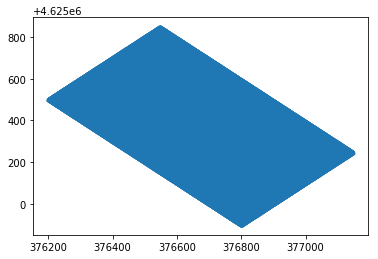

In [7]:
plt.scatter(xu, yu, marker='.')

In [8]:
# originally, I thought I'd make the rotated box in xarray, and somehow interpolate, but this is a dead end.
dsbox = xr.DataArray(np.NaN*np.ones_like(xu))#, coords=[('northing', yu),('easting', xu)])
#dsr = ds.interp(,method='linear')

In [9]:
dsbox

<xarray.DataArray (dim_0: 1201, dim_1: 401)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Dimensions without coordinates: dim_0, dim_1

In [10]:
# This is promising, but doesn't work because I don't know how to get the array of values using xarray:
from scipy import interpolate
x, y = np.meshgrid(ds['x'].values, ds['y'].values,sparse=False, indexing='xy')
z = np.double(ds['band'].values)
print(np.shape(x),np.shape(y),np.shape(z))
f = interpolate.interp2d(x, y, z, kind='linear')

(10226, 11987) (10226, 11987) ()


ValueError: Invalid length for input z for non rectangular grid

In [11]:
ds['band'].values

array([1])

In [10]:
# Plan B: Use rasterio but not xarray
with rasterio.open(fn) as src:
        # location of origin (upper left) from transform
        xo,yo = src.transform*(0,0)
        print('xo,yo: ',xo,yo)
        # index of first col, row in window from inverse transform
        xy = ~src.transform*(e0, n0)
        xoff, yoff = int(xy[0]), int(xy[1])
        print("xoff, yoff: ",xoff, yoff)
        print(src.bounds)
        print("width and height: ",src.width, src.height)
        zt = src.read(1)
        src.close()

xo,yo:  376286.64299908397 4625440.8344103005
xoff, yoff:  -866 -591
BoundingBox(left=376286.64299908397, bottom=4624418.234410301, right=377485.3429990839, top=4625440.8344103005)
width and height:  11987 10226


In [11]:
# Coordinates of the tiff file
x, y = np.meshgrid( np.linspace(src.bounds.left, src.bounds.right, src.width), \
                   np.linspace(src.bounds.top, src.bounds.bottom, src.height) )
print(x)
print(y)

[[ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]
 [ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]
 [ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]
 ..., 
 [ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]
 [ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]
 [ 376286.64299908  376286.74300743  376286.84301577 ...,  377485.1429824
   377485.24299074  377485.34299908]]
[[ 4625440.8344103   4625440.8344103   4625440.8344103  ...,
   4625440.8344103   4625440.8344103   4625440.8344103 ]
 [ 4625440.73440052  4625440.73440052  4625440.73440052 ...,
   4625440.73440052  4625440.73440052  4625440.73440052]
 [ 4625440.63439074  4625440.63439074  4625440.63439074 ...,
   4625440.63439074  4625440.

In [ ]:
# plt.pcolor(x,y,zt)

In [14]:
from scipy import interpolate
print(np.shape(x),np.shape(y),np.shape(zt))
f = interpolate.interp2d(x, y, zt, kind='linear')

(10226, 11987) (10226, 11987) (10226, 11987)


OverflowError: Too many data points to interpolate

In [50]:
# from https://stackoverflow.com/questions/5328128/scipy-interpolation-of-large-matrix#5329386
from scipy import interpolate

def my_interp(X, Y, Z, x, y, spn=7):

    # get the indices of the nearest x,y
    xi = np.argmin(np.abs(X[0,:]-x))
    yi = np.argmin(np.abs(Y[:,0]-y))
    xlo = max(xi-spn, 0)
    ylo = max(yi-spn, 0)
    xhi = min(xi+spn, X[0,:].size)
    yhi = min(yi+spn, Y[:,0].size)
    # make slices of X,Y,Z that are only a few items wide
    nX = X[xlo:xhi, ylo:yhi]
    nY = Y[xlo:xhi, ylo:yhi]
    nZ = Z[xlo:xhi, ylo:yhi]
    intp = interpolate.interp2d(nX, nY, nZ, 'linear')
    z = intp(x,y)
    return z

In [53]:
zi=np.ones_like(xu)
for i in range(nx-2):
    for j in range(ny-2):
        zi[i,j]=my_interp(x, y, zt, xu[i,j],yu[i,j])

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=16,17 m=196 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,15 m=196 fp=0.000074 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: No more knots can be added be

IndexError: index 401 is out of bounds for axis 1 with size 401

In [52]:
zi

array([[  3.41024327e+00,   3.65803719e+00,   3.91484427e+00, ...,
         -3.27670000e+04,  -3.27670000e+04,  -3.27670000e+04],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

In [23]:
np.shape(y)

(10226, 11987)

In [24]:
np.shape(zt)

(10226, 11987)

In [25]:
zt[1,1]

-32767.0

In [28]:
zt[400,800]

1.290696

In [30]:
xu[200,200]

376873.20508075686